## Amdahl's Law 

Improving a portion $p$ of a computation by factor $s$ results in an overall speedup of

$$S_{\mbox{latency}}(s) = \frac{1}{1-p+\frac{p}{s}}$$

* _p_ is the proportion of execution time that benefits from improved resources, i.e. the parallel part
* _(1-p)_ is the portion that does not benefit; i.e. the serial part
* _s_ is the speedup of the optimized part
* _S<sub>latency</sub>(s)_ theoretical speedup of the whole task

Paraphrased: speedup limited to fraction improved

<img src="./images/al2.png" width="512" title="Amdahl's Law Graph (from Greg Ganger)" />

### Visualizing Amdahl's Law

Let's look at the Amdahl curve for a given parallel fraction (.95).


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


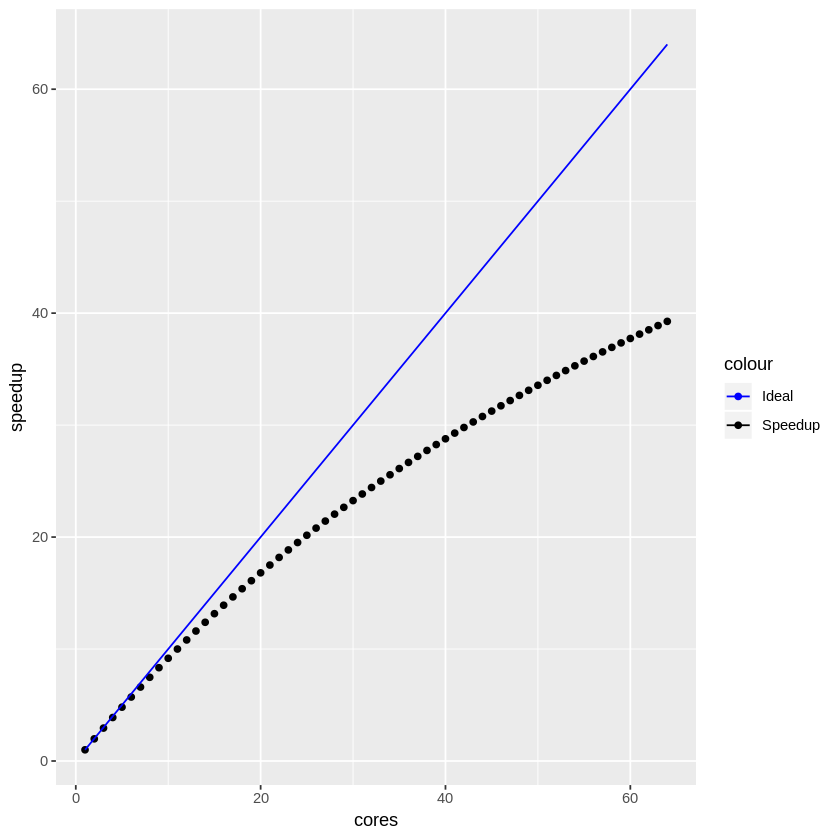

In [2]:
library(ggplot2)

# Let's assume we have a 4 socket x 16 core machine.  So up to 64 cores.
cores = seq(1:1:64)

p = .99
        
amdahl <- data.frame(cores, 1/((1-p)+p/cores))
colnames(amdahl) <- c("cores","speedup")

aplot <- ggplot(amdahl, aes(x=cores, y=speedup, color="Speedup")) + geom_point() +
            geom_line(data=amdahl, aes(x=cores,y=cores, color="Ideal")) +
            scale_color_manual(values = c("Speedup" = 'black','Ideal' = 'blue'))

print(aplot)



### Scaling

Let's now look at how performance scales as function of the parallel fraction.

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.1     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ dplyr   0.8.1
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  2.1.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


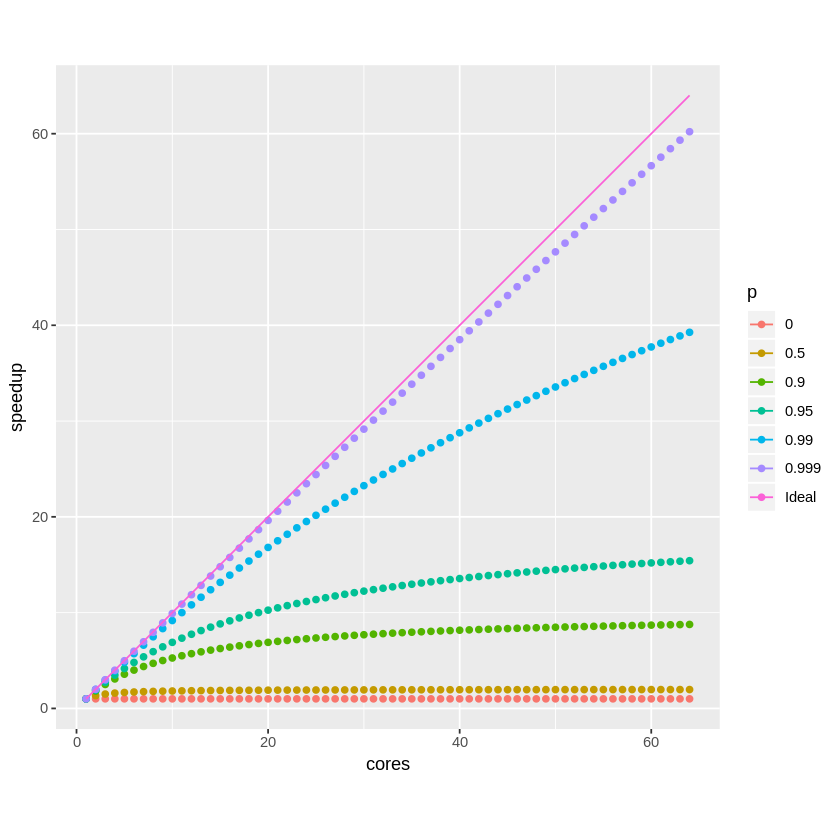

In [3]:
library(ggplot2)
library(tidyverse)

# Let's assume we have a 4 socket x 16 core machine.  So up to 64 cores.
cores = seq(1:1:64)

# and a parallel fraction of 99%
p = factor(c(0,.5,.9,.95,.99,.999))

# build a data frame 
df <- data.frame(crossing(cores,p))
df$pnumeric <- as.numeric(levels(df$p))[df$p]

# with speedup
df$speedup <- 1/((1-df$pnumeric)+df$pnumeric/df$cores)

plt <- ggplot(df, aes(x=cores, y=speedup))+geom_point(aes(color=p)) +
            geom_line(data=df, aes(x=cores,y=cores, color="Ideal")) +
            coord_fixed()

print(plt)

OK, that's a little underwhelming.  Let's look at this the other way around.

* Supposing you want to achieve a speedup of 80 with 100 processors, what fraction of the original computation can be sequential?

In [4]:
# 80 = 1 / ((1-p)+p/100)
p = (100-100/80)/99
p

[1] 0.9974747

Amdahl's law indicates that even a small degree of unoptimized code limits performance.

### So what is sequential?

We say 'sequential' as a simple abstraction for the unopitmized portion.

An abstraction to reason about parallelism.
* Sometimes literal:
  * Outer/control thread in OpenMP
  * File system I/O before launching a program
* Sometimes metaphorical:
  * When one/few processes are running while others are idle 
  * When parallelism introduces additional computation

The unoptimized fraction of the code occurs
when not all resources are doing useful work at full capacity.

### Infering parallelism from Amdahl's Law

Simplifying unoptimized into sequential and parallel allows us to infer an __Amdahl Number__ from 
the exmpirical performance of a code.

* Supposing you want to achieve a speedup of 80 with 100 processors, what fraction of the original computation can be unoptimized?

$$p = \frac{n}{(n-1)} * \left(1 - \frac{1}{S}\right)$$

In [5]:
# 80 = 1 / ((1-p)+p/100)
p = (100-100/80)/99
p

[1] 0.9974747

The practice is to measure the _speedup_ of a code and use that speedup to infer the Amdah number.

In [6]:
# we measure perforamnce as a function of cores. 
processors = c(2,4,8,16,32)
speedup = c(1.85, 3.30, 5.34, 7.4, 9.4)
amdahl_number <- processors/(processors-1)*(1-1/speedup)
amdahl_number

[1] 0.9189189 0.9292929 0.9288390 0.9225225 0.9224434

So, we would say that this code seems to have an Amdahl # of about .92.  The can be converted into a maximum possible speedup.

* Amdahl's law implies that the unoptimized fraction of the code dictates exactly how much speedup can be obtained on __an infinite number of cores__.

$$S_{\mbox{latency}}(s) = \frac{1}{1-p+\frac{p}{\infty}} = \frac{1}{1-p}$$

In [7]:
slim <- 1/(1-0.92)
slim

[1] 12.5

Warning message:
“Removed 108 rows containing missing values (geom_path).”

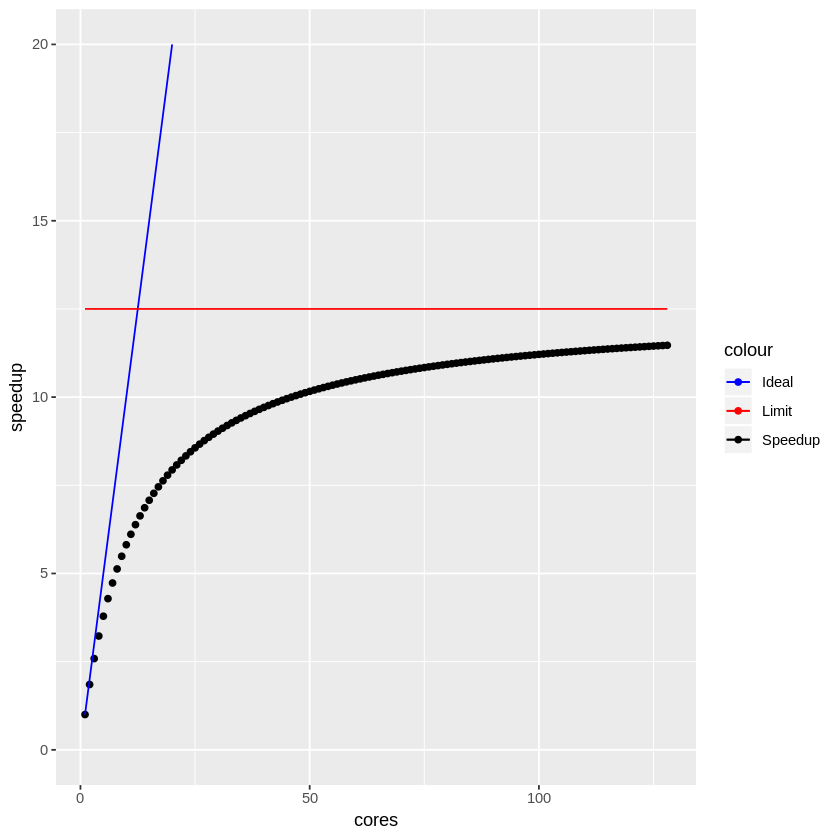

In [8]:
# Let's assume we have a 4 socket x 16 core machine.  So up to 64 cores.
cores = seq(1:1:128)

p = .92
        
amdahl <- data.frame(cores, slim, 1/((1-p)+p/cores))
colnames(amdahl) <- c("cores", "limit", "speedup")

aplot <- ggplot(amdahl, aes(x=cores, y=speedup, color="Speedup")) + geom_point() +
            geom_line(data=amdahl, aes(x=cores,y=cores, color="Ideal")) +
            geom_line(data=amdahl, aes(x=cores,y=limit, color="Limit")) +
            scale_color_manual(values = c("Speedup" = 'black','Ideal' = 'blue', 'Limit'='red')) + ylim(0,20)
print(aplot)



### Parting Thoughts

Performance in practice is much more complex than splitting a code into a "unoptimized" and "optimized" portion.  But we will see that Amdahl's law is incredibly useful in:
  * Back of the envelope calculations about scalability limits (setting a speed limit)
  * Deciding what portions of a complex software applciation is worth optimizing
We will revisit these applications multiple times.